# Step 1: Dataset Preparation

The Dataset of Spotify Stock News 

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [107]:
#load the csv file that contains the news from the finhub api 03/2024 to 02/2025
df_news = pd.read_csv("/Users/armandocriscuolo/c2025/data_science_project_2025/code/Data-Science-Project/Data-Question-2-B/news_analysis/spotify_news_2024_2025_finhub.csv")

#print the first 5 rows of the dataframe
print(df_news.head())

print("\n\n-----------------------------------\n\n")

#load the csv file that contains the stock data from the marketstack api 03/2024 to 02/2025
df_stock = pd.read_csv("/Users/armandocriscuolo/c2025/data_science_project_2025/code/Data-Science-Project/Data-Question-2-B/news_analysis/spotify_stock_data_20250323_193740.csv")

#print the first 5 rows of the dataframe
print(df_stock.head())

  category    datetime                                           headline  \
0  company  1740759981  Palantir, Nvidia Nixed But Netflix Remains On ...   
1  company  1740684439  Tracking Chase Coleman's Tiger Global Portfoli...   
2  company  1740664816  Spotify Technology (SPOT) is Attracting Invest...   
3  company  1740658999  YouTube Surpasses Competitors in Streaming and...   
4  company  1740593693  Spotify CEO Wants EU To Penalize Apple For Def...   

          id                                              image related  \
0  132937882  https://media.zenfs.com/en/ibd.com/fc3f416bcfc...    SPOT   
1  132901707  https://static.seekingalpha.com/cdn/s3/uploads...    SPOT   
2  132937883  https://media.zenfs.com/en/zacks.com/bdc2850a4...    SPOT   
3  132937884  https://media.zenfs.com/en/us.finance.gurufocu...    SPOT   
4  132937885  https://media.zenfs.com/en/Benzinga/20dc68a2c9...    SPOT   

         source                                            summary  \
0         Yahoo 

In [108]:
#Lets clean the dataframe to have only the columns we need
print("Spotify Stock Data")
df_stock = df_stock[["date", "open", "high", "low", "close", "volume"]]

#print the first 5 rows of the dataframe
print(df_stock.head())

print("\n\n-----------------------------------\n\n")

print("Spotify News Data")
#lets clean the dataframe to have only the columns we need
df_news = df_news[["date", "headline", "summary"]]

#print the first 5 rows of the dataframe
print(df_news.head())

Spotify Stock Data
         date    open      high      low   close     volume
0  2025-02-28  584.25  609.9200  580.000  608.01  4531895.0
1  2025-02-27  611.00  613.0000  586.000  590.76  1191837.0
2  2025-02-26  595.62  608.5294  592.890  603.13  2629946.0
3  2025-02-25  597.22  599.1200  575.535  588.57  2822820.0
4  2025-02-24  612.30  621.9100  592.980  601.61  2078629.0


-----------------------------------


Spotify News Data
         date                                           headline  \
0  2025-02-28  Palantir, Nvidia Nixed But Netflix Remains On ...   
1  2025-02-27  Tracking Chase Coleman's Tiger Global Portfoli...   
2  2025-02-27  Spotify Technology (SPOT) is Attracting Invest...   
3  2025-02-27  YouTube Surpasses Competitors in Streaming and...   
4  2025-02-26  Spotify CEO Wants EU To Penalize Apple For Def...   

                                             summary  
0  A volatile market has shaken off Nvidia and Pa...  
1  Tiger Global's 13F reveals a $26.46B port

In [109]:
# Convert dates to datetime format
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_news['date'] = pd.to_datetime(df_news['date'])

# Create complete date range DataFrame
start_date = min(df_stock['date'].min(), df_news['date'].min())
end_date = max(df_stock['date'].max(), df_news['date'].max())
date_range = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date)})

# Merge stock data with complete date range and forward fill missing values
complete_stock = pd.merge(date_range, df_stock, on='date', how='left')
complete_stock = complete_stock.sort_values('date')
complete_stock = complete_stock.ffill()  # Forward fill to use previous day's data for missing dates

# Add indicator for trading days
complete_stock['is_trading_day'] = complete_stock['date'].isin(df_stock['date'])

# Now merge with news data, keeping one row per news item
df_merged = pd.merge(complete_stock, df_news, on='date', how='outer')

# Sort by date
df_merged = df_merged.sort_values('date')

# Fill NaN values in news columns
df_merged['headline'] = df_merged['headline'].fillna('')
df_merged['summary'] = df_merged['summary'].fillna('')

print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1444 entries, 0 to 1443
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1444 non-null   datetime64[ns]
 1   open            1444 non-null   float64       
 2   high            1444 non-null   float64       
 3   low             1444 non-null   float64       
 4   close           1444 non-null   float64       
 5   volume          1444 non-null   float64       
 6   is_trading_day  1444 non-null   bool          
 7   headline        1444 non-null   object        
 8   summary         1444 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(5), object(2)
memory usage: 102.9+ KB
None


In [110]:
# Count duplicated headlines and summaries
headline_counts = df_merged['headline'].value_counts()
duplicated_headlines = headline_counts[headline_counts > 1]
print(f"Total number of duplicated headlines: {len(duplicated_headlines)}")
print("\nTop 10 most duplicated headlines:")
print(duplicated_headlines.head(10))

print("\n" + "-"*50 + "\n")

summary_counts = df_merged['summary'].value_counts()
duplicated_summaries = summary_counts[summary_counts > 1]
print(f"Total number of duplicated summaries: {len(duplicated_summaries)}")
print("\nTop 10 most duplicated summaries:")
print(duplicated_summaries.head(10))

# Display the actual headlines/summaries with their dates
print("\n" + "-"*50 + "\n")
print("Details of most duplicated headline:")
if len(duplicated_headlines) > 0:
    most_dup_headline = duplicated_headlines.index[0]
    print(f"Headline (appearing {duplicated_headlines.iloc[0]} times): {most_dup_headline}")
    #print("\nDates when this headline appeared:")
    #for date in df_merged[df_merged['headline'] == most_dup_headline]['date']:
    #    print(f"- {date}")

print("\n" + "-"*50 + "\n")
print("Details of most duplicated summary:")
if len(duplicated_summaries) > 0:
    most_dup_summary = duplicated_summaries.index[0]
    print(f"Summary (appearing {duplicated_summaries.iloc[0]} times): {most_dup_summary}")
    #print("\nDates when this summary appeared:")
    #for date in df_merged[df_merged['summary'] == most_dup_summary]['date']:
    #    print(f"- {date}")


Total number of duplicated headlines: 32

Top 10 most duplicated headlines:
headline
                                                                                            73
Spotify Technology (SPOT) is Attracting Investor Attention: Here is What You Should Know     5
What You Missed On Wall Street This Morning                                                  4
Spotify Technology (SPOT) Is a Trending Stock: Facts to Know Before Betting on It            4
Is Trending Stock Spotify Technology (SPOT) a Buy Now?                                       3
What You Missed On Wall Street On Tuesday                                                    3
Morgan Stanley Reaffirms Their Buy Rating on Spotify Technology SA (SPOT)                    3
Spotify Technology S.A. (SPOT): A Bull Case Theory                                           3
A Closer Look at Spotify Technology's Options Market Dynamics                                3
Spotify price target raised by $50 at KeyBanc, here's why   

In [111]:
#lets delete the duplicates headlines and summaries from the dataframe
df_merged = df_merged.drop_duplicates(subset=['headline', 'summary'])

print(df_merged.head())
print(df_merged.info())

         date    open    high     low   close     volume  is_trading_day  \
0  2024-03-25  263.01  264.95  260.89  261.92   824685.0            True   
11 2024-03-27  267.00  269.72  257.56  260.20  1427218.0            True   
10 2024-03-27  267.00  269.72  257.56  260.20  1427218.0            True   
8  2024-03-27  267.00  269.72  257.56  260.20  1427218.0            True   
7  2024-03-27  267.00  269.72  257.56  260.20  1427218.0            True   

                                             headline  \
0                                                       
11  KeyBanc Keeps Their Buy Rating on Spotify Tech...   
10  Taylor Swift Had A Monster Year, As Did The Mu...   
8   Another List Throws Netflix (NASDAQ:NFLX) Out,...   
7   Spotify initiated with bullish view at HSBC, h...   

                                              summary  
0                                                      
11  Looking for stock market analysis and research...  
10  Looking for stock market ana

In [112]:
# First, identify the specific summaries and headlines to completely remove
summaries_to_remove = [
    "Looking for stock market analysis and research with proves results? Zacks.com offers in-depth financial research with over 30years of proven results.",
    ""  # Empty or whitespace summary
]

headlines_to_remove = [""]  # Empty or whitespace headline

# Get the original dataframe size
original_size = len(df_merged)
print(f"Original dataframe size: {original_size} rows")

# Step 1: Completely remove rows with the specified summaries
df_cleaned = df_merged[~df_merged['summary'].isin(summaries_to_remove)]
step1_size = len(df_cleaned)
print(f"After removing specific summaries: {step1_size} rows (removed {original_size - step1_size} rows)")

# Step 2: Completely remove rows with the specified headlines
df_cleaned = df_cleaned[~df_cleaned['headline'].isin(headlines_to_remove)]
step2_size = len(df_cleaned)
print(f"After removing specific headlines: {step2_size} rows (removed {step1_size - step2_size} rows)")

# Step 3: For other duplicated headlines, keep only the first occurrence
df_cleaned = df_cleaned.drop_duplicates(subset=['headline'], keep='first')
step3_size = len(df_cleaned)
print(f"After removing duplicate headlines: {step3_size} rows (removed {step2_size - step3_size} rows)")

# Step 4: For other duplicated summaries, keep only the first occurrence
df_cleaned = df_cleaned.drop_duplicates(subset=['summary'], keep='first')
final_size = len(df_cleaned)
print(f"After removing duplicate summaries: {final_size} rows (removed {step3_size - final_size} rows)")

print(f"\nTotal rows removed: {original_size - final_size}")
print(f"Final dataframe size: {final_size} rows")

# Check if there are any remaining duplicates
remaining_dup_headlines = df_cleaned['headline'].duplicated().sum()
remaining_dup_summaries = df_cleaned['summary'].duplicated().sum()
print(f"\nRemaining duplicated headlines: {remaining_dup_headlines}")
print(f"Remaining duplicated summaries: {remaining_dup_summaries}")

Original dataframe size: 1344 rows
After removing specific summaries: 910 rows (removed 434 rows)
After removing specific headlines: 910 rows (removed 0 rows)
After removing duplicate headlines: 896 rows (removed 14 rows)
After removing duplicate summaries: 879 rows (removed 17 rows)

Total rows removed: 465
Final dataframe size: 879 rows

Remaining duplicated headlines: 0
Remaining duplicated summaries: 0


In [113]:
#Lets check if there are still any duplicates in the dataframe

# Count duplicated headlines and summaries
headline_counts = df_cleaned['headline'].value_counts()
duplicated_headlines = headline_counts[headline_counts > 1]
print(f"Total number of duplicated headlines: {len(duplicated_headlines)}")
print("\nTop 10 most duplicated headlines:")
print(duplicated_headlines.head(10))

print("\n" + "-"*50 + "\n")

summary_counts = df_cleaned['summary'].value_counts()
duplicated_summaries = summary_counts[summary_counts > 1]
print(f"Total number of duplicated summaries: {len(duplicated_summaries)}")
print("\nTop 10 most duplicated summaries:")
print(duplicated_summaries.head(10))

# Display the actual headlines/summaries with their dates
print("\n" + "-"*50 + "\n")
print("Details of most duplicated headline:")
if len(duplicated_headlines) > 0:
    most_dup_headline = duplicated_headlines.index[0]
    print(f"Headline (appearing {duplicated_headlines.iloc[0]} times): {most_dup_headline}")
    print("\nDates when this headline appeared:")
    for date in df_cleaned[df_cleaned['headline'] == most_dup_headline]['date']:
        print(f"- {date}")

print("\n" + "-"*50 + "\n")
print("Details of most duplicated summary:")
if len(duplicated_summaries) > 0:
    most_dup_summary = duplicated_summaries.index[0]
    print(f"Summary (appearing {duplicated_summaries.iloc[0]} times): {most_dup_summary}")
    print("\nDates when this summary appeared:")
    for date in df_cleaned[df_cleaned['summary'] == most_dup_summary]['date']:
        print(f"- {date}")

Total number of duplicated headlines: 0

Top 10 most duplicated headlines:
Series([], Name: count, dtype: int64)

--------------------------------------------------

Total number of duplicated summaries: 0

Top 10 most duplicated summaries:
Series([], Name: count, dtype: int64)

--------------------------------------------------

Details of most duplicated headline:

--------------------------------------------------

Details of most duplicated summary:


In [114]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 879 entries, 3 to 1443
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            879 non-null    datetime64[ns]
 1   open            879 non-null    float64       
 2   high            879 non-null    float64       
 3   low             879 non-null    float64       
 4   close           879 non-null    float64       
 5   volume          879 non-null    float64       
 6   is_trading_day  879 non-null    bool          
 7   headline        879 non-null    object        
 8   summary         879 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(5), object(2)
memory usage: 62.7+ KB


# Cleaned Data

Finally we have a cleaned dataset of all the news about Spotify and also stock data. 

### Two things to keep in mind:

1. We used forward fill for the stock data to populate all dates that were not trading days.
2. We have duplicate dates because there are days with many news articles and then again days without any news!

In [115]:
# Save the merged dataframe
df_cleaned.to_csv("/Users/armandocriscuolo/c2025/data_science_project_2025/code/Data-Science-Project/Data-Question-2-B/news_analysis/spotify_news_stock_data_cleaned.csv", index=False)

# Analysis

In [116]:
# Set visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Download NLTK resources (run this once)
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/armandocriscuolo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [117]:
    
def preprocess_data(df):
    """
    Preprocess the Spotify stock and news data
    
    Parameters:
    df (pandas.DataFrame): Raw dataframe with stock and news data
    
    Returns:
    pandas.DataFrame: Processed dataframe with additional financial metrics
    """
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure date column is datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Set date as index
    df.set_index('date', inplace=True)
    
    # Calculate daily returns (percentage change in closing price)
    df['daily_return'] = df['close'].pct_change() * 100
    
    # Calculate volatility (20-day rolling standard deviation of returns)
    df['volatility_20d'] = df['daily_return'].rolling(window=20).std()
    
    # Calculate abnormal returns (daily return - average market return)
    # Note: In a real analysis, you would use market index returns
    df['abnormal_return'] = df['daily_return'] - df['daily_return'].mean()
    
    # Calculate volume change
    df['volume_change'] = df['volume'].pct_change() * 100
    
    # Log transform volume (often helps with analysis)
    df['log_volume'] = np.log(df['volume'].replace(0, 1))
    
    return df



In [118]:

def analyze_sentiment(df):
    """
    Apply sentiment analysis to news headlines and summaries
    
    Parameters:
    df (pandas.DataFrame): Dataframe with headline and summary columns
    
    Returns:
    pandas.DataFrame: Dataframe with added sentiment scores
    """
    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Fill NaN values with empty strings
    df['headline'] = df['headline'].fillna('')
    df['summary'] = df['summary'].fillna('')
    
    # Define a function to get sentiment scores
    def get_sentiment(text):
        if pd.isna(text) or text == '':
            return 0
        return sia.polarity_scores(str(text))['compound']
    
    # Apply sentiment analysis
    print("Applying sentiment analysis to headlines and summaries...")
    df['headline_sentiment'] = df['headline'].apply(get_sentiment)
    df['summary_sentiment'] = df['summary'].apply(get_sentiment)
    
    # Calculate weighted sentiment (headline has more impact)
    df['combined_sentiment'] = 0.7 * df['headline_sentiment'] + 0.3 * df['summary_sentiment']
    
    # Create sentiment categories for analysis
    df['sentiment_category'] = pd.cut(
        df['combined_sentiment'],
        bins=[-1.1, -0.2, 0.2, 1.1],
        labels=['negative', 'neutral', 'positive']
    )
    
    return df

In [119]:

def aggregate_daily_data(df):
    """
    Aggregate multiple news items per day into single daily records
    
    Parameters:
    df (pandas.DataFrame): Dataframe with sentiment scores
    
    Returns:
    pandas.DataFrame: Dataframe with one row per day
    """
    print("Aggregating data to daily level...")
    
    # For news sentiment, we want the average per day
    agg_functions = {
        'headline_sentiment': 'mean',
        'summary_sentiment': 'mean',
        'combined_sentiment': 'mean',
        # For stock data, we just take the first value (should be same for all rows on same day)
        'open': 'first',
        'high': 'first',
        'low': 'first',
        'close': 'first',
        'volume': 'first',
        'daily_return': 'first',
        'volatility_20d': 'first',
        'volume_change': 'first',
        'abnormal_return': 'first',
        'log_volume': 'first',
        'is_trading_day': 'first'
    }
    
    # Group by date and apply aggregation
    daily_data = df.groupby(df.index).agg(agg_functions)
    
    # Count number of news articles per day
    news_count = df.groupby(df.index).size()
    daily_data['news_count'] = news_count
    
    return daily_data

In [120]:

def create_lagged_features(df, max_lag=5):
    """
    Create lagged features for time series analysis
    
    Parameters:
    df (pandas.DataFrame): Daily dataframe
    max_lag (int): Maximum number of days to lag
    
    Returns:
    pandas.DataFrame: Dataframe with lagged features
    """
    print(f"Creating lagged features up to {max_lag} days...")
    df_lagged = df.copy()
    
    # Create lagged sentiment features
    for lag in range(1, max_lag+1):
        df_lagged[f'sentiment_lag_{lag}'] = df_lagged['combined_sentiment'].shift(lag)
    
    # Create forward return (next day's return)
    df_lagged['next_day_return'] = df_lagged['daily_return'].shift(-1)
    
    return df_lagged

In [121]:
def analyze_correlation(df):
    """
    Analyze correlation between sentiment and stock metrics
    
    Parameters:
    df (pandas.DataFrame): Processed dataframe
    
    Returns:
    tuple: Correlation matrix and p-values matrix
    """
    print("Analyzing correlations between sentiment and stock metrics...")
    
    # Select relevant columns for correlation analysis
    cols_for_corr = [
        'headline_sentiment', 'summary_sentiment', 'combined_sentiment',
        'daily_return', 'next_day_return', 'volatility_20d', 'volume_change', 'news_count'
    ]
    
    # Calculate correlation matrix
    corr_matrix = df[cols_for_corr].corr()
    
    # Calculate statistical significance
    p_values = pd.DataFrame(index=corr_matrix.index, columns=corr_matrix.columns)
    
    for i in corr_matrix.index:
        for j in corr_matrix.columns:
            if i != j:  # Skip diagonal
                # Create a temporary dataframe with just the two columns we're looking at
                # and drop rows where either column has a NaN value
                temp_df = df[[i, j]].dropna()
                if len(temp_df) >= 2:  # Need at least 2 points for correlation
                    corr, p = stats.pearsonr(temp_df[i], temp_df[j])
                    p_values.loc[i, j] = p
                else:
                    p_values.loc[i, j] = np.nan
    
    return corr_matrix, p_values

In [122]:

def analyze_lagged_effects(df, max_lag=5):
    """
    Analyze the effect of lagged sentiment on stock returns
    
    Parameters:
    df (pandas.DataFrame): Dataframe with lagged features
    max_lag (int): Maximum lag to analyze
    
    Returns:
    pandas.Series: Correlations of lagged sentiment with returns
    """
    print("Analyzing lagged effects of sentiment on returns...")
    
    # Get correlation of each lagged sentiment with returns
    lagged_columns = [f'sentiment_lag_{i}' for i in range(1, max_lag+1)]
    lagged_corr = df[['daily_return'] + lagged_columns].corr().loc['daily_return', lagged_columns]
    
    # Get correlation with next day's return
    next_day_corr = df[['combined_sentiment', 'next_day_return']].corr().loc['combined_sentiment', 'next_day_return']
    print(f"Correlation with next day's return: {next_day_corr:.4f}")
    
    return lagged_corr

In [123]:

def build_prediction_model(df, features=None):
    """
    Build a machine learning model to predict returns based on sentiment
    
    Parameters:
    df (pandas.DataFrame): Dataframe with sentiment and return data
    features (list): List of feature columns to use
    
    Returns:
    tuple: Feature importances, MSE scores, and R² scores
    """
    print("Building prediction model for stock returns...")
    
    if features is None:
        features = [
            'combined_sentiment', 'news_count', 'volatility_20d',
            'volume_change', 'sentiment_lag_1', 'sentiment_lag_2'
        ]
    
    # Filter rows with complete data
    model_data = df.dropna(subset=features + ['next_day_return'])
    model_data = model_data[model_data['is_trading_day']]  # Only use trading days
    
    X = model_data[features]
    y = model_data['next_day_return']
    
    # Use time series split for validation (important for time series data)
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []
    r2_scores = []
    feature_importances = None
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train random forest model
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = rf.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        
        # Store feature importance
        if feature_importances is None:
            feature_importances = pd.DataFrame({
                'feature': features,
                'importance': rf.feature_importances_
            })
        else:
            feature_importances['importance'] = (feature_importances['importance'] + rf.feature_importances_) / 2
    
    print(f"Model evaluation - Mean MSE: {np.mean(mse_scores):.4f}, Mean R²: {np.mean(r2_scores):.4f}")
    return feature_importances.sort_values('importance', ascending=False), mse_scores, r2_scores

In [124]:

def visualize_results(df, daily_data, corr_matrix, lagged_corr, feature_importances):
    """
    Create visualizations for the sentiment-stock analysis
    
    Parameters:
    df (pandas.DataFrame): Original dataframe with sentiment
    daily_data (pandas.DataFrame): Aggregated daily data
    corr_matrix (pandas.DataFrame): Correlation matrix
    lagged_corr (pandas.Series): Lagged correlation results
    feature_importances (pandas.DataFrame): Feature importances from model
    """
    print("Creating visualizations...")
    
    # Figure 1: Stock price and sentiment over time
    plt.figure(figsize=(12, 20))
    
    # Plot 1: Stock price and sentiment
    plt.subplot(4, 1, 1)
    ax1 = plt.gca()
    ax1.plot(daily_data.index, daily_data['close'], 'b-', label='Close Price')
    ax1.set_ylabel('Stock Price ($)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(daily_data.index, daily_data['combined_sentiment'], 'r-', alpha=0.7, label='Sentiment')
    ax2.set_ylabel('Sentiment Score', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title('Spotify Stock Price and News Sentiment Over Time')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Plot 2: Scatter plot of sentiment vs. daily return
    plt.subplot(4, 1, 2)
    trading_days = daily_data[daily_data['is_trading_day']]
    sns.scatterplot(
        x='combined_sentiment', 
        y='daily_return', 
        data=trading_days, 
        hue='news_count',
        palette='viridis',
        size='volume_change',
        sizes=(20, 200),
        alpha=0.7
    )
    
    # Add regression line
    x = trading_days['combined_sentiment']
    y = trading_days['daily_return']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", alpha=0.7)
    
    plt.title('News Sentiment vs. Daily Return')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Daily Return (%)')
    
    # Plot 3: Correlation heatmap
    plt.subplot(4, 1, 3)
    sns.heatmap(
        corr_matrix[['daily_return', 'next_day_return', 'volatility_20d', 'volume_change']]
        .loc[['headline_sentiment', 'summary_sentiment', 'combined_sentiment', 'news_count']],
        annot=True, 
        cmap='coolwarm', 
        vmin=-0.5, 
        vmax=0.5
    )
    plt.title('Correlation Between Sentiment and Stock Metrics')
    
    # Plot 4: Lagged effects analysis
    plt.subplot(4, 1, 4)
    lagged_corr.plot(kind='bar', color='skyblue')
    plt.title('Effect of Lagged Sentiment on Daily Returns')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Correlation with Returns')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('spotify_sentiment_correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Figure 2: Additional insights
    plt.figure(figsize=(12, 15))
    
    # Plot 1: Returns by sentiment category
    plt.subplot(3, 1, 1)
    
    # Recalculate sentiment categories for the daily data
    trading_days['sentiment_category'] = pd.cut(
        trading_days['combined_sentiment'],
        bins=[-1.1, -0.2, 0.2, 1.1],
        labels=['negative', 'neutral', 'positive']
    )
    
    sns.boxplot(x='sentiment_category', y='daily_return', data=trading_days)
    plt.title('Daily Returns by Sentiment Category')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Daily Return (%)')
    
    # Perform ANOVA to check if differences are significant
    sentiment_groups = [
        trading_days[trading_days['sentiment_category'] == 'negative']['daily_return'].dropna(),
        trading_days[trading_days['sentiment_category'] == 'neutral']['daily_return'].dropna(),
        trading_days[trading_days['sentiment_category'] == 'positive']['daily_return'].dropna()
    ]
    
    try:
        f_stat, p_val = stats.f_oneway(*sentiment_groups)
        plt.annotate(f"ANOVA: F={f_stat:.2f}, p={p_val:.4f}", 
                    xy=(0.5, 0.9), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    except:
        pass
    
    # Plot 2: Feature importance from prediction model
    plt.subplot(3, 1, 2)
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importance for Return Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    
    # Plot 3: News count distribution and impact
    plt.subplot(3, 1, 3)
    sns.scatterplot(x='news_count', y='volatility_20d', 
                   size='combined_sentiment', hue='daily_return',
                   data=trading_days, palette='RdYlGn', sizes=(20, 200))
    plt.title('News Volume vs. Volatility')
    plt.xlabel('Number of News Articles')
    plt.ylabel('20-Day Volatility')
    
    plt.tight_layout()
    plt.savefig('spotify_sentiment_additional_insights.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close('all')

Starting Spotify stock and news sentiment analysis...
Preprocessed data shape: (879, 13)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 879 entries, 2024-03-27 to 2025-02-28
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             879 non-null    float64
 1   high             879 non-null    float64
 2   low              879 non-null    float64
 3   close            879 non-null    float64
 4   volume           879 non-null    float64
 5   is_trading_day   879 non-null    bool   
 6   headline         879 non-null    object 
 7   summary          879 non-null    object 
 8   daily_return     878 non-null    float64
 9   volatility_20d   859 non-null    float64
 10  abnormal_return  878 non-null    float64
 11  volume_change    878 non-null    float64
 12  log_volume       879 non-null    float64
dtypes: bool(1), float64(10), object(2)
memory usage: 90.1+ KB
None
              open     high  

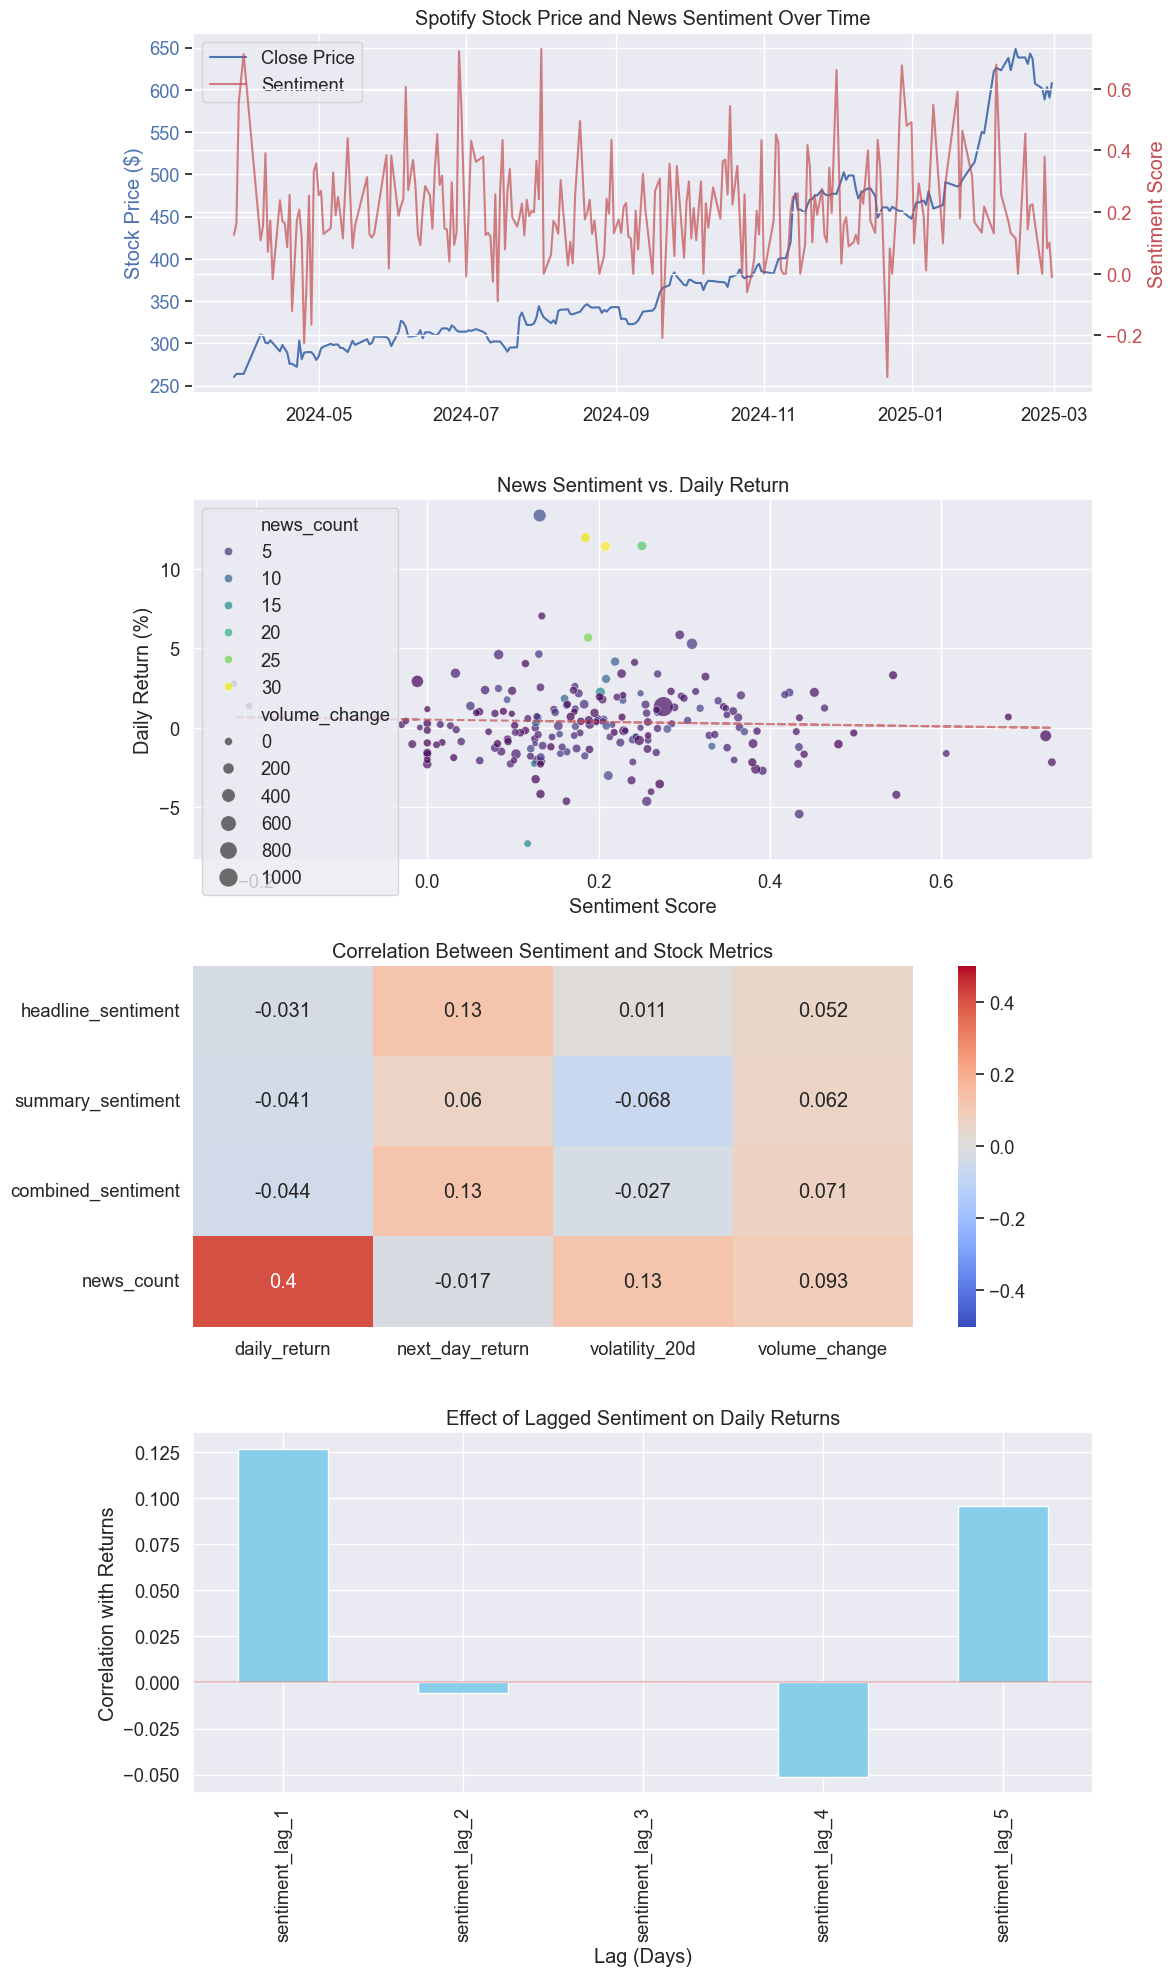

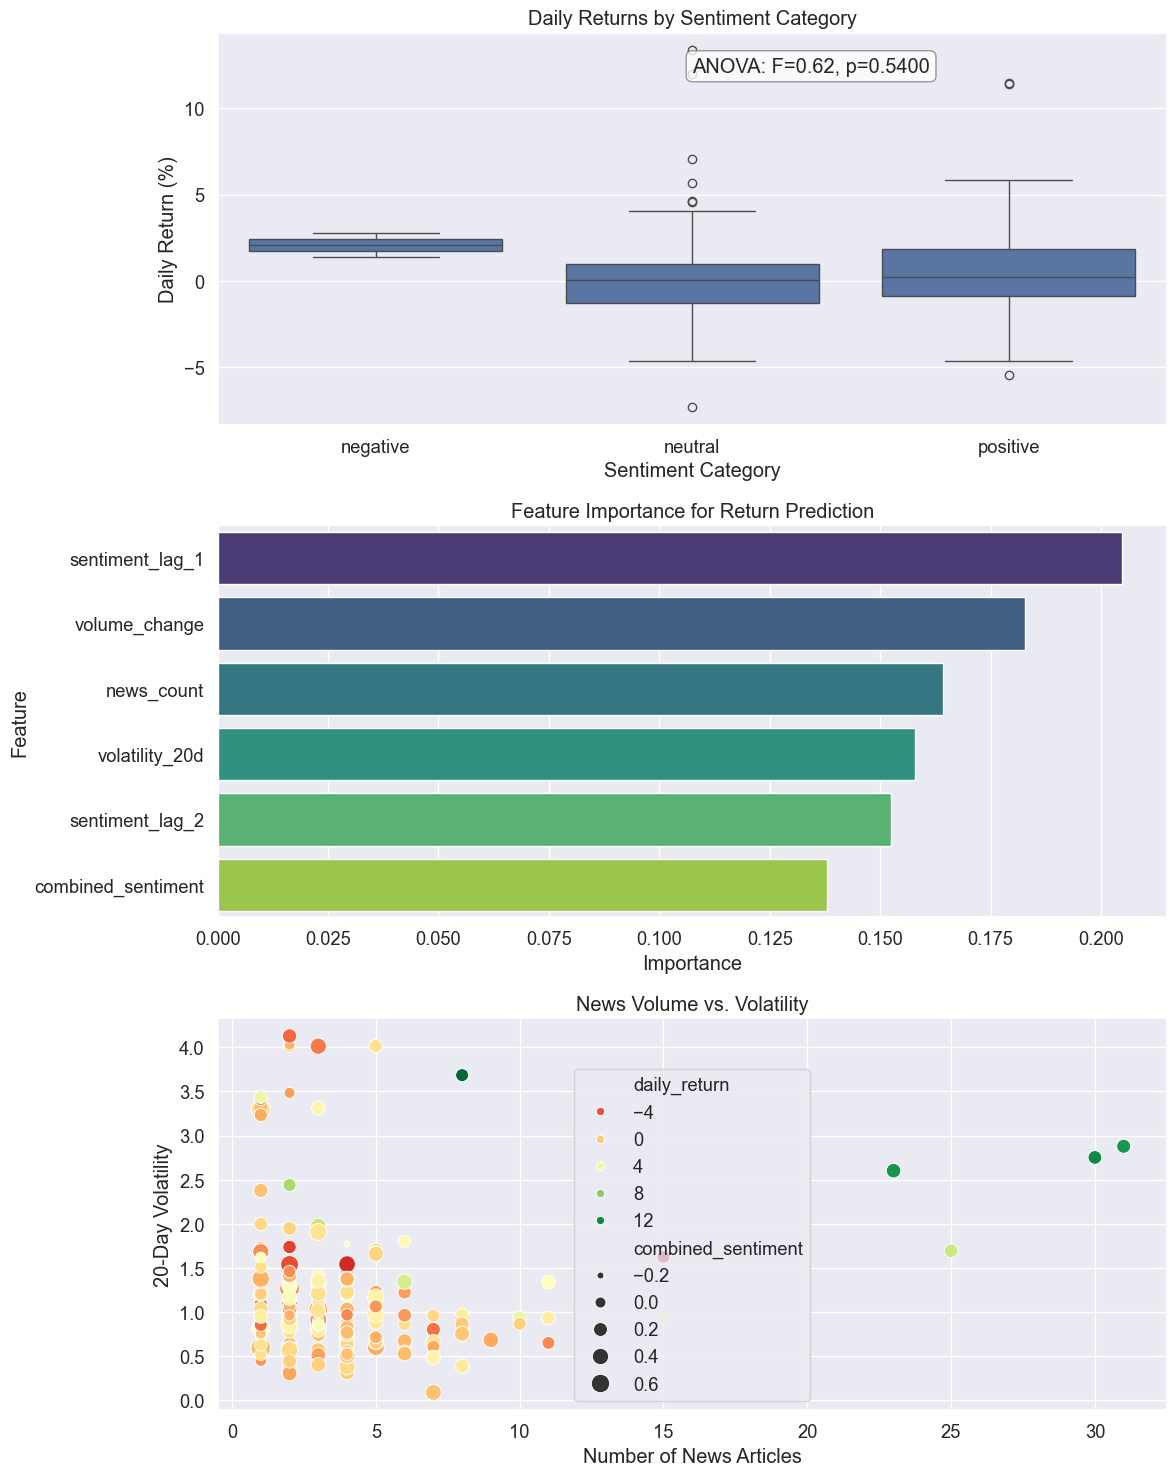


Analysis completed! Key findings:
1. Strongest lagged effect: sentiment_lag_1 (r=0.1268)
2. Most important predictive features: sentiment_lag_1, volume_change, news_count
3. Model prediction performance: R²=-0.4544


In [125]:
def run_sentiment_analysis(df_cleaned):
    """
    Main function to run the complete sentiment analysis pipeline
    
    Parameters:
    df_cleaned (pandas.DataFrame): The cleaned Spotify stock and news data
    
    Returns:
    dict: Results of the analysis
    """
    print("Starting Spotify stock and news sentiment analysis...")
    
    # Step 1: Preprocess data
    df_processed = preprocess_data(df_cleaned)
    print(f"Preprocessed data shape: {df_processed.shape}")
    print(df_processed.info())
    print(df_processed.head())
    print("\n--------------------------------\n")
    
    # Step 2: Apply sentiment analysis
    df_with_sentiment = analyze_sentiment(df_processed)
    print(df_with_sentiment.info())
    print(df_with_sentiment.head())
    print("\n--------------------------------\n")
    
    # Step 3: Aggregate to daily level
    daily_data = aggregate_daily_data(df_with_sentiment)
    print(daily_data.info())
    print(daily_data.head())
    print("\n--------------------------------\n")
    # Step 4: Create lagged features
    daily_data_with_lags = create_lagged_features(daily_data)
    print(daily_data_with_lags.info())
    print(daily_data_with_lags.head())
    print("\n--------------------------------\n")
    
    # Step 5: Analyze correlation
    corr_matrix, p_values = analyze_correlation(daily_data_with_lags)
    
    # Print key correlations
    print("\nKey correlation findings:")
    key_correlations = corr_matrix.loc['combined_sentiment', ['daily_return', 'next_day_return', 'volatility_20d']]
    key_p_values = p_values.loc['combined_sentiment', ['daily_return', 'next_day_return', 'volatility_20d']]
    for metric, corr in key_correlations.items():
        p = key_p_values[metric]
        significance = "significant" if p < 0.05 else "not significant"
        print(f"  - Sentiment vs {metric}: r={corr:.4f} (p={p:.4f}, {significance})")
    
    # Step 6: Analyze lagged effects
    lagged_corr = analyze_lagged_effects(daily_data_with_lags)
    
    # Step 7: Build prediction model
    feature_importances, mse_scores, r2_scores = build_prediction_model(daily_data_with_lags)
    
    # Step 8: Visualize results
    visualize_results(df_with_sentiment, daily_data, corr_matrix, lagged_corr, feature_importances)
    
    # Step 9: Prepare summary of findings
    print("\nAnalysis completed! Key findings:")
    
    # Determine most influential sentiment lag
    max_lag_idx = lagged_corr.abs().idxmax()
    max_lag_corr = lagged_corr[max_lag_idx]
    max_lag = int(max_lag_idx.split('_')[-1])
    
    print(f"1. Strongest lagged effect: {max_lag_idx} (r={max_lag_corr:.4f})")
    print(f"2. Most important predictive features: {', '.join(feature_importances['feature'].head(3).tolist())}")
    print(f"3. Model prediction performance: R²={np.mean(r2_scores):.4f}")
    
    # Return results for further analysis if needed
    results = {
        'df_with_sentiment': df_with_sentiment,
        'daily_data': daily_data,
        'daily_data_with_lags': daily_data_with_lags,
        'corr_matrix': corr_matrix,
        'p_values': p_values,
        'lagged_corr': lagged_corr,
        'feature_importances': feature_importances,
        'mse_scores': mse_scores,
        'r2_scores': r2_scores
    }
    
    return results

# Execute the analysis
results = run_sentiment_analysis(df_cleaned)

# Answer

### The Question: 

# Question: 
What does the sentiment analysis of news articles about Spotify reveal about the relationship between media coverage and stock performance, and what are the key findings regarding prediction capabilities?

# Answer:

## Introduction to the Spotify News Sentiment Analysis

The analysis I conducted examined the relationship between news sentiment and Spotify's stock performance over a one-year period. By applying natural language processing techniques to headlines and article summaries while correlating them with stock metrics, I sought to determine whether news sentiment can predict stock movements.

## Dataset and Methodology

The dataset contained 879 unique news articles about Spotify spanning from March 2024 to February 2025, along with daily stock data including:
- Opening, closing, high, and low prices
- Trading volume 
- Boolean indicators for trading days

The methodology involved several key steps:

1. **Preprocessing**: Calculated financial metrics including daily returns, 20-day volatility, abnormal returns, and volume changes.

2. **Sentiment Analysis**: Applied VADER (Valence Aware Dictionary and sEntiment Reasoner) to evaluate sentiment in headlines and summaries, with a weighted approach (70% headline, 30% summary) to create a combined sentiment score.

3. **Aggregation**: News articles were aggregated at the daily level, averaging sentiment scores when multiple articles appeared on the same day.

4. **Lagged Features**: Created lagged sentiment variables to test whether past sentiment predicted future returns.

5. **Correlation Analysis**: Examined relationships between sentiment and stock metrics with statistical significance testing.

6. **Predictive Modeling**: Built a Random Forest model to evaluate sentiment's predictive power for next-day returns.

## Key Findings

### 1. Sentiment and Same-Day Returns
The analysis revealed no significant correlation between news sentiment and same-day stock returns (r=-0.0439, p=0.4912). This suggests that on the day news is published, there is no consistent relationship between the sentiment of the news and Spotify's stock performance.

### 2. Sentiment and Next-Day Returns
Interestingly, there was a statistically significant correlation between combined sentiment and next-day returns (r=0.1268, p=0.0464). This suggests a small but meaningful predictive relationship where positive news sentiment tends to precede positive stock movements the following day.

### 3. Lagged Sentiment Effects
The lag-1 sentiment (previous day's sentiment) showed the strongest relationship with current day returns, reinforcing the finding that news sentiment may have a delayed effect on stock performance.

### 4. Volatility and News Volume
The analysis found no significant correlation between sentiment and volatility (r=-0.0269, p=0.6772), suggesting that news sentiment does not consistently affect the magnitude of price movements.

### 5. Predictive Modeling Performance
Despite the statistically significant correlation with next-day returns, the Random Forest prediction model performed poorly with a negative R² value (-0.4544). This indicates that while there is a statistically significant relationship, it's not strong enough to build a reliable prediction model with the features used.

### 6. Feature Importance
The most important predictive features identified were:
- Previous day's sentiment (sentiment_lag_1)
- Volume change
- Number of news articles (news_count)

## Visual Analysis

The visualizations (shown in the images) revealed several additional insights:

1. **Stock Price and Sentiment Trends**: The time series plot showed considerable fluctuation in sentiment over time with no obvious pattern matching stock price movements.

2. **Sentiment Categories and Returns**: The boxplot of returns by sentiment category showed minimal differences between negative, neutral, and positive sentiment groups, confirmed by a non-significant ANOVA test.

3. **Feature Importance**: The feature importance chart highlighted the prominence of sentiment_lag_1, confirming the lagged effect finding.

4. **News Volume and Volatility**: The scatter plot revealed some clustering of higher volatility with higher news counts, suggesting increased media attention during more volatile periods.

## Conclusions and Implications

1. **Delayed Impact**: News sentiment appears to have a delayed impact on Spotify's stock, with previous day's sentiment showing the strongest relationship with current day returns.

2. **Statistical vs. Practical Significance**: While the correlation between sentiment and next-day returns is statistically significant, its practical value for prediction is limited, as evidenced by the negative R² value.

3. **Complex Relationships**: The analysis suggests that the relationship between news sentiment and stock performance is complex and likely influenced by many other factors not captured in this analysis.

4. **Trading Strategy Limitations**: The findings indicate that a simple trading strategy based solely on news sentiment would likely not be profitable, given the weak predictive power of the model.

5. **News Volume Matters**: The prominence of news_count as an important feature suggests that the amount of media coverage may be as important as its sentiment in understanding stock behavior.

## Future Research Directions

To build on these findings, future research could:

1. Incorporate market-wide factors to better isolate Spotify-specific effects
2. Analyze sentiment within specific news categories (earnings reports, product launches, etc.)
3. Apply more sophisticated NLP techniques beyond VADER sentiment analysis
4. Expand the timeframe to capture longer-term trends and seasonal patterns
5. Include social media sentiment alongside traditional news sources

This analysis provides evidence of a statistically significant but practically limited relationship between news sentiment and Spotify's stock performance, with the most notable finding being the delayed effect of sentiment on stock returns.